In [22]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Exploratory Data Analysis

First let us read the data into a pandas DataFrame.

In [2]:
original_data = pd.read_excel('data.xlsx')

In [3]:
print 'Number of samples: ', original_data.shape[0]

Number of samples:  296


It will be useful to isolate the columns which deal with scores.  We will also clean up the column label by removing the trailing '_17' in each score field.

In [4]:
score_cols = [col for col in original_data.columns if 'score' in col]

# Replace trailing '_17' in label
for i in range(len(score_cols)):
    original_data.rename(columns={score_cols[i]: score_cols[i][:-3]}, inplace=True)
    score_cols[i] = score_cols[i][:-3]

## Data Distributions

First let us visualize the frequency counts of the score labels, to see how complete the data is.

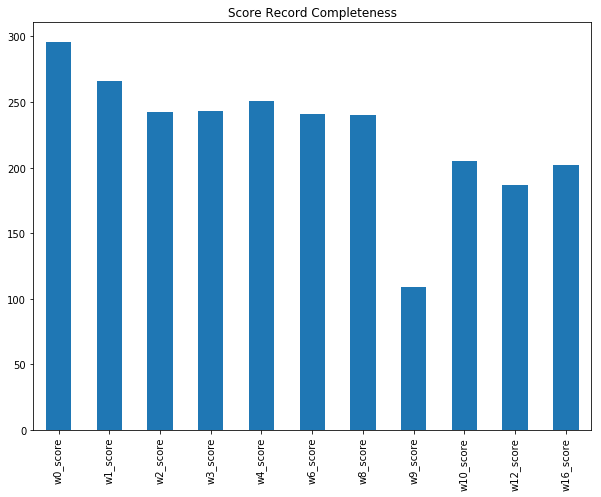

In [8]:
original_data[score_cols].count().plot(kind='bar', title='Score Record Completeness', figsize=(10,7.5))

Next let's plot the completeness of each row with respect to w0 to w8 scores.

In [9]:
first_trial_scores = score_cols[:7]  # w0 to w8
original_data['valid_scores'] = original_data[first_trial_scores].notnull().sum(axis=1)

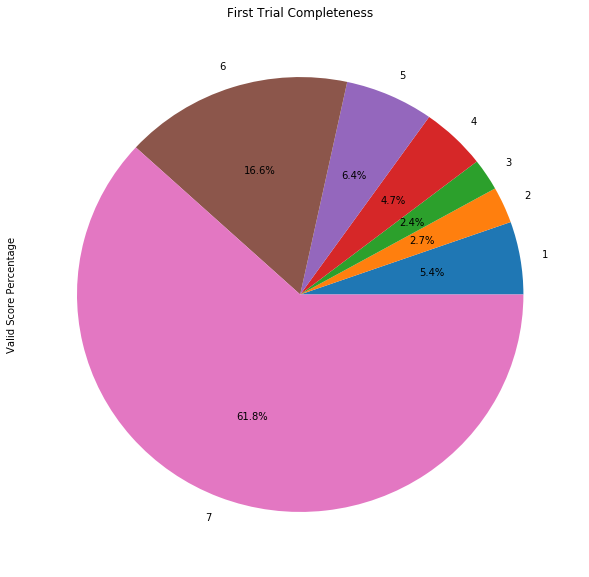

In [10]:
pd.Series(original_data.groupby(['valid_scores']).size() / original_data.shape[0], name="Valid Score Percentage").plot(kind='pie', autopct='%1.1f%%', title='First Trial Completeness', figsize=(10,10))

Next we will investigate the value distribution of each score period.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e653d90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11ec22b10>]], dtype=object)

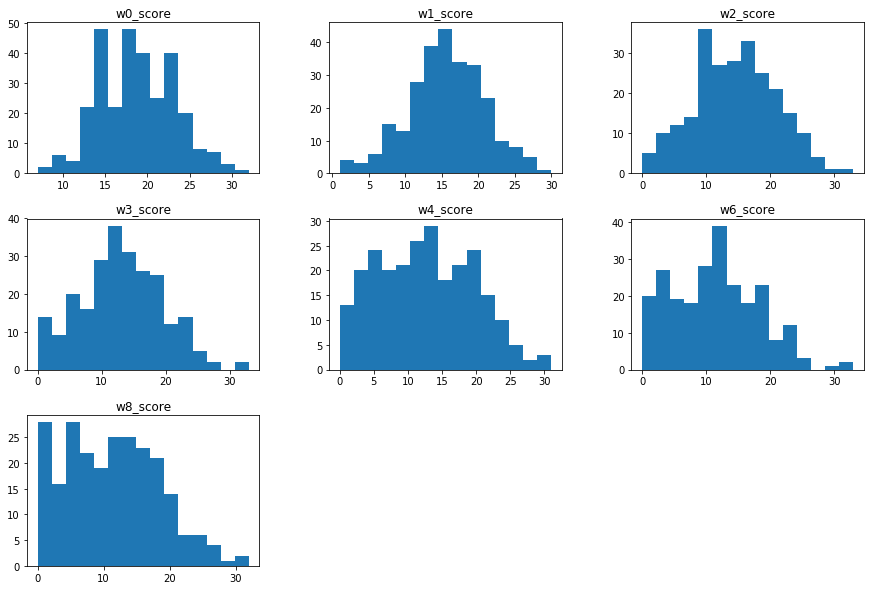

In [38]:
original_data.hist(column=first_trial_scores, grid=False, figsize=(15,10), bins=15)

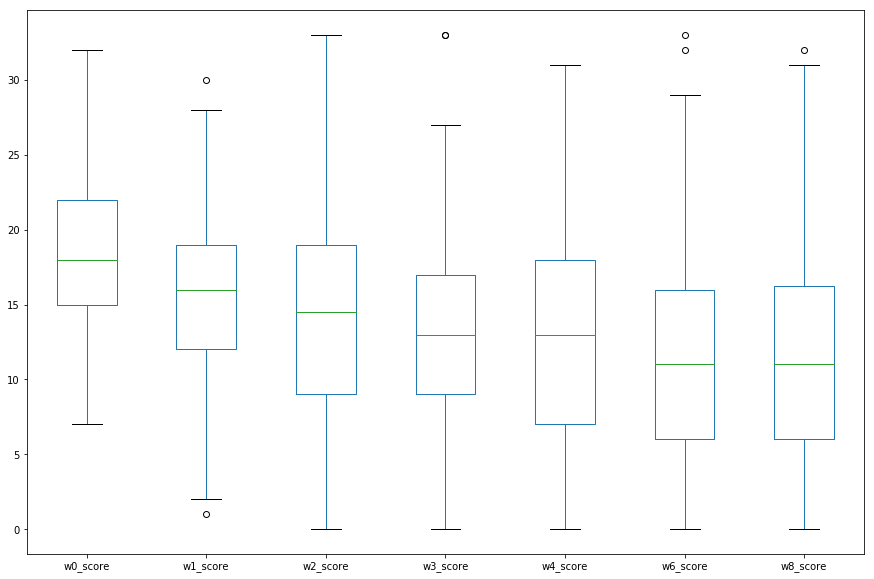

In [40]:
original_data.boxplot(column=first_trial_scores, grid=False, figsize=(15,10))